In [1]:
%env TF_USE_LEGACY_KERAS=1

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

env: TF_USE_LEGACY_KERAS=1


In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = "/content/drive/My Drive/scraped_images/dataset"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 309 files belonging to 2 classes.
Using 248 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 309 files belonging to 2 classes.
Using 61 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['grass', 'non-grass']


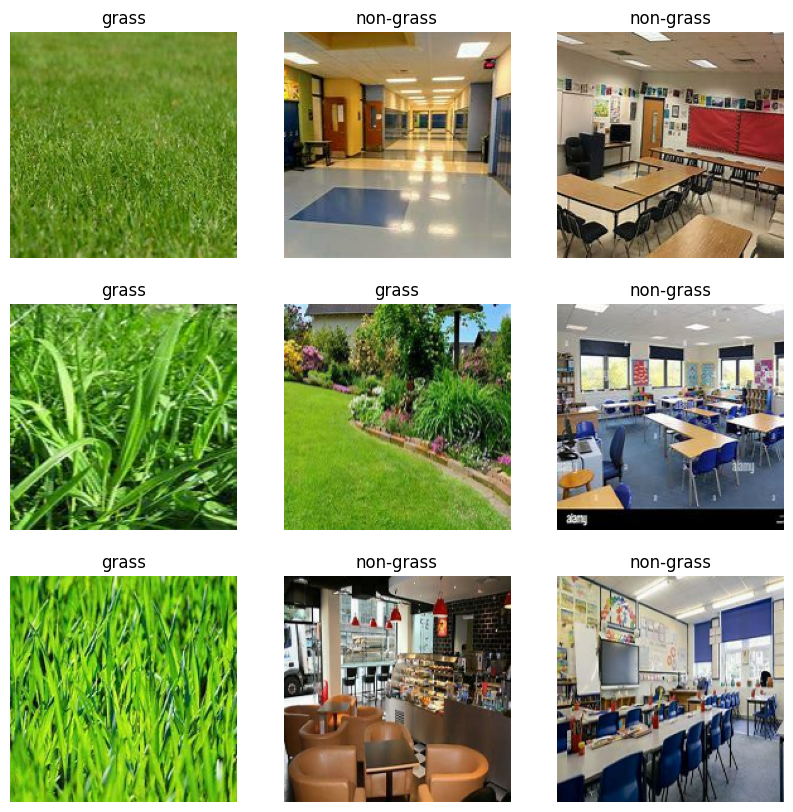

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
8/8 [==============================] - 16s 2s/step - loss: 1.2090 - accuracy: 0.5000 - val_loss: 0.5969 - val_accuracy: 0.5738
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 0.4285 - accuracy: 0.8065 - val_loss: 0.2527 - val_accuracy: 0.8852
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.1985 - accuracy: 0.9435 - val_loss: 0.1886 - val_accuracy: 0.9344
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.1327 - accuracy: 0.9476 - val_loss: 0.3887 - val_accuracy: 0.8689
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.2065 - accuracy: 0.9476 - val_loss: 0.2521 - val_accuracy: 0.8852
Epoch 6/10
8/8 [==============================] - 8s 972ms/step - loss: 0.1584 - accuracy: 0.9435 - val_loss: 0.1813 - val_accuracy: 0.9344
Epoch 7/10
8/8 [==============================] - 10s 1s/step - loss: 0.0984 - accuracy: 0.9798 - val_loss: 0.1641 - val_accuracy: 0.9344
Epoch 8/10
8/8 [================

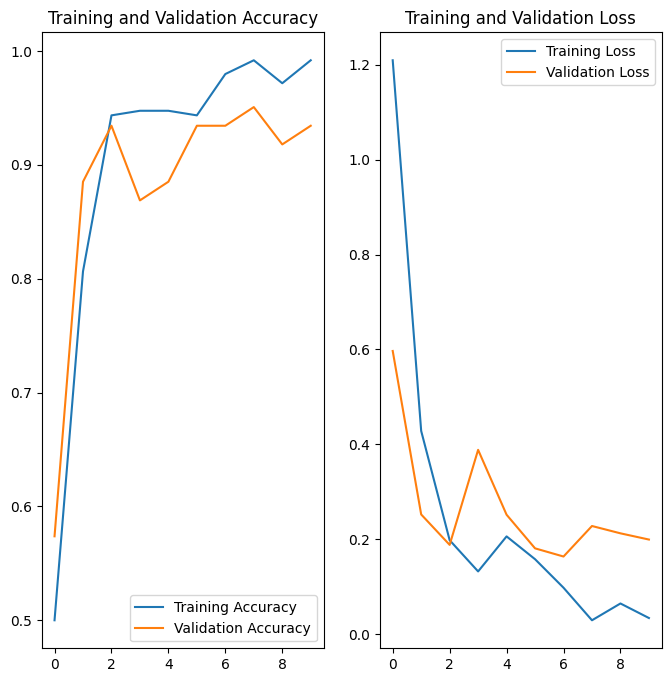

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_path = "/content/drive/MyDrive/scraped_images/OIP (1).jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
This image most likely belongs to grass with a 99.69 percent confidence.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

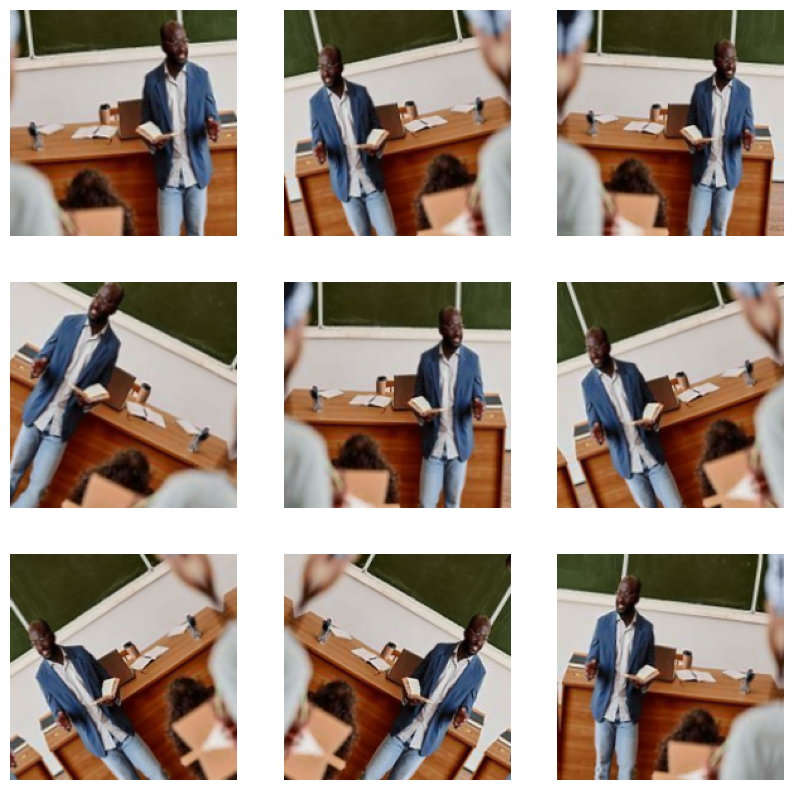

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
2/8 ━━━━━━━━━━━━━━━━━━━━ 5s 971ms/step - accuracy: 0.3438 - loss: 0.8588

KeyboardInterrupt: 

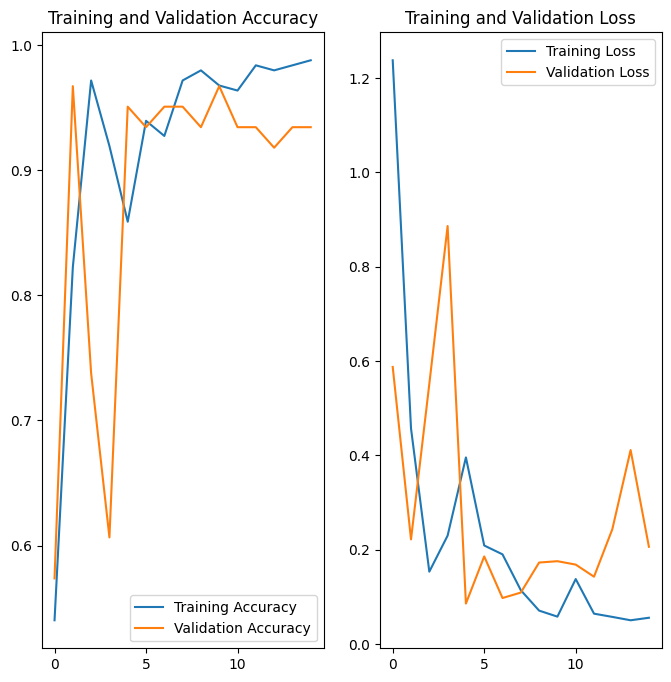

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
saved_model_dir = '/content/drive/MyDrive/saved_model.keras'
model.save(saved_model_dir)

TypeError: cannot pickle 'module' object

In [20]:
!pip install tensorflowjs

import tensorflow as tf
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/scraped_images/tfjs_model")

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("/content/drive/MyDrive/scraped_images/tfl_model", 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpaqh_4x4d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133050302846880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302851984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050473799648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050474035712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050474033952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302855856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302847056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302914000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302911008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133050302917696: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
import tensorflow as tf

tflite_model_path = '/content/drive/MyDrive/scraped_images/tfl_model'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [ ]:
import tensorflowjs as tfjs

saved_model_dir = '/content/drive/MyDrive/saved_model'
tfjs_model_dir = '/content/drive/MyDrive/tfjs_model'

# Convert the SavedModel to TensorFlow.js format
tfjs.converters.save_keras_model(tf.keras.models.load_model(saved_model_dir), tfjs_model_dir)